#### Import các thư viện cần thiết

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

#### Xác định phần cứng và cố định tham số ngẫu nhiên

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benckmark = False

SEED = 42
set_seed(SEED)

#### Tải bộ dữ liệu

In [3]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', 
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

#### Chia bộ dữ liệu train/val/test

In [4]:
train_ratio = 0.9
batch_size = 128
train_size = int(len(train_dataset) * train_ratio) 
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train size: {len(train_subset)}')
print(f'Validation size: {len(val_subset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


#### Xây dựng mô hình

In [5]:
# Custom Gradient Normalization Layer
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forwar pass: pass input unchanged
        ctx.save_for_backward(input)
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        # Normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        return grad_input

# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = GradientNormalizationLayer()(x)

        out = self.output(x)
        return out
    
input_dims = 784 # (28, 28)
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

#### Huấn luyện mô hình

In [7]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)
    
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        loss = criterion(outputs, y_val)
        val_loss += loss.item()
        val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
        count += len(y_val)
    
    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 1.7601, Train_Acc: 0.2277, Validation Loss: 1.5591, Val_Acc: 0.2733
EPOCH 2/100, Train_Loss: 1.5649, Train_Acc: 0.2863, Validation Loss: 1.3667, Val_Acc: 0.3623
EPOCH 3/100, Train_Loss: 1.3440, Train_Acc: 0.3706, Validation Loss: 1.2999, Val_Acc: 0.3890
EPOCH 4/100, Train_Loss: 1.2950, Train_Acc: 0.3776, Validation Loss: 1.2820, Val_Acc: 0.3793
EPOCH 5/100, Train_Loss: 1.2973, Train_Acc: 0.3766, Validation Loss: 1.3274, Val_Acc: 0.3708
EPOCH 6/100, Train_Loss: 1.3242, Train_Acc: 0.3595, Validation Loss: 1.3138, Val_Acc: 0.3722
EPOCH 7/100, Train_Loss: 1.2965, Train_Acc: 0.3711, Validation Loss: 1.8301, Val_Acc: 0.3030
EPOCH 8/100, Train_Loss: 1.2533, Train_Acc: 0.4075, Validation Loss: 1.3265, Val_Acc: 0.3665
EPOCH 9/100, Train_Loss: 1.1911, Train_Acc: 0.4531, Validation Loss: 1.1313, Val_Acc: 0.5435
EPOCH 10/100, Train_Loss: 1.0921, Train_Acc: 0.5246, Validation Loss: 1.1163, Val_Acc: 0.5327
EPOCH 11/100, Train_Loss: 1.0576, Train_Acc: 0.5432, Validation Loss:

#### Trực quan hóa

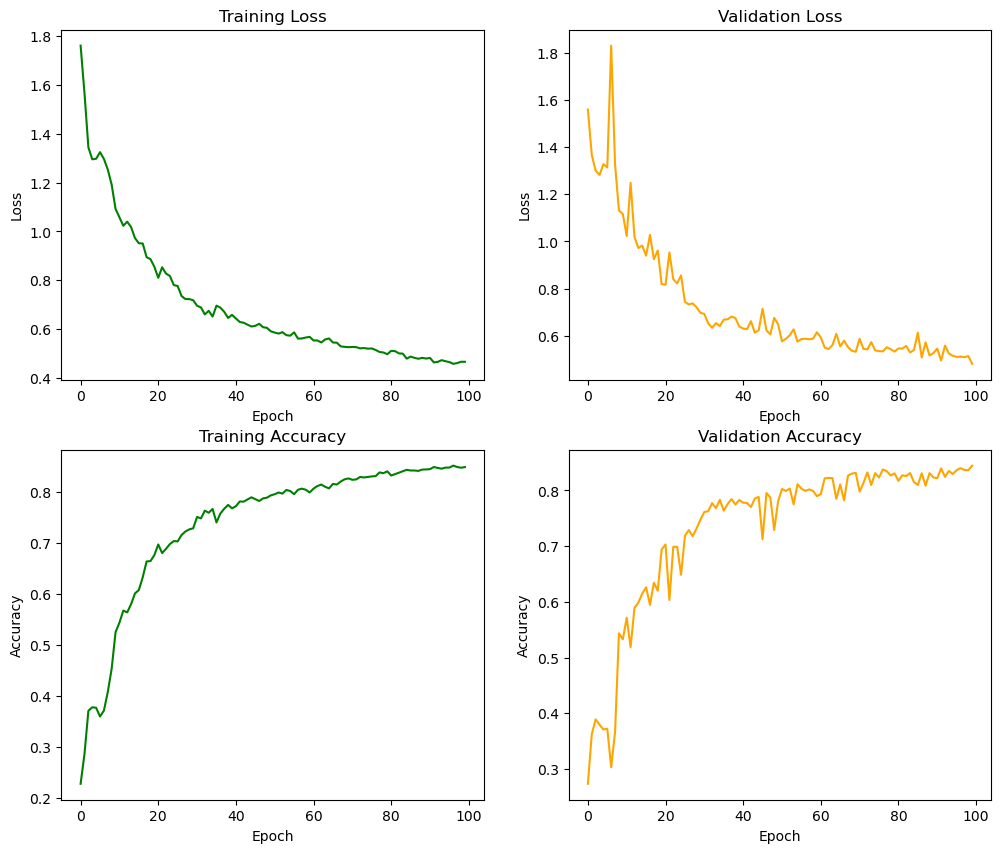

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [9]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader: 
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8405
